# Robot Control WS22/23
## 3R Roboter

Date:    **07.02.2022** \
Author:  **Kaufmann Stefan**   
Ma. Nr.: **51867606**




In [1]:
"""
Date: 20.12.2022
Author: Kaufmann Stefan

Robot Control - Simulation 3R Roboter 
"""

import numpy as np
import sympy as sym
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
from Model import model_nlin
#sym.init_printing()
from IPython.display import display


# 2. Modellbildung

![Alt text](fig/3R_Manipulator.png)



$
J = 
\begin{bmatrix}
J_{v} \\
J_{\omega}
\end{bmatrix}
$ mit 
$J = 
\begin{bmatrix}
\dot{x} \\ \dot{y} \\ \dot{z} \\
\dot{\omega_{x}} \\ \dot{\omega_{y}} \\ \dot{\omega_{z}} 
\end{bmatrix}$


In [2]:
from Kinematik_3R import *
# Den Sourcecode finden Sie unter Kinematik_3R.py
# Das Laden der Symbolischen Rechnung kann etwas Zeit in anspruch nehmen. 

''' Jacobimatrix '''
# zum Abspielen eingach die gewünsche Variable entkommentieren

#Jv_1
#Jv_2
display(Jv_3)

#Jw_1
#Jw_2
display(Jw_3)


Matrix([
[-l1*sin(q1) - l2*sin(q1 + q2) - l_s3*sin(q1 + q2 + q3), -l2*sin(q1 + q2) - l_s3*sin(q1 + q2 + q3), -l_s3*sin(q1 + q2 + q3)],
[ l1*cos(q1) + l2*cos(q1 + q2) + l_s3*cos(q1 + q2 + q3),  l2*cos(q1 + q2) + l_s3*cos(q1 + q2 + q3),  l_s3*cos(q1 + q2 + q3)],
[                                                     0,                                         0,                       0]])

Matrix([
[0, 0, 0],
[0, 0, 0],
[1, 1, 1]])

In [3]:
''' Kinetische Energie und Massenmatrix '''

display(D)

Matrix([
[I1 + I2 + I3 + l1**2*m2 + l1**2*m3 + 2*l1*l2*m3*cos(q2) + 2*l1*l_s2*m2*cos(q2) + 2*l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s1**2*m1 + l_s2**2*m2 + l_s3**2*m3, I2 + I3 + l1*l2*m3*cos(q2) + l1*l_s2*m2*cos(q2) + l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s2**2*m2 + l_s3**2*m3, I3 + l1*l_s3*m3*cos(q2 + q3) + l2*l_s3*m3*cos(q3) + l_s3**2*m3],
[                                              I2 + I3 + l1*l2*m3*cos(q2) + l1*l_s2*m2*cos(q2) + l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s2**2*m2 + l_s3**2*m3,                                                                   I2 + I3 + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s2**2*m2 + l_s3**2*m3,                           I3 + l2*l_s3*m3*cos(q3) + l_s3**2*m3],
[                                                                                                                     I3 + l1*l_s3*m3*cos(q2 + q3) + l2*l_s3*m3*cos(q3) + l_s3**2*m3,                                              

In [4]:
''' Christoffel Symbole'''
display(C)

# qd  = erste Zeitableitung des Gelenkes
# qdd = zweite Zeitableitung des Gelenkes

Matrix([
[-1.0*l1*qd2*(l2*m3*sin(q2) + l_s2*m2*sin(q2) + l_s3*m3*sin(q2 + q3)) - 1.0*l_s3*m3*qd3*(l1*sin(q2 + q3) + l2*sin(q3)), -1.0*l1*qd1*(l2*m3*sin(q2) + l_s2*m2*sin(q2) + l_s3*m3*sin(q2 + q3)) - 1.0*l1*qd2*(l2*m3*sin(q2) + l_s2*m2*sin(q2) + l_s3*m3*sin(q2 + q3)) - 1.0*l_s3*m3*qd3*(l1*sin(q2 + q3) + l2*sin(q3)), -1.0*l_s3*m3*(l1*sin(q2 + q3) + l2*sin(q3))*(qd1 + qd2 + qd3)],
[                     1.0*l1*qd1*(l2*m3*sin(q2) + l_s2*m2*sin(q2) + l_s3*m3*sin(q2 + q3)) - 1.0*l2*l_s3*m3*qd3*sin(q3),                                                                                                                                                                 -1.0*l2*l_s3*m3*qd3*sin(q3),                     -1.0*l2*l_s3*m3*(qd1 + qd2 + qd3)*sin(q3)],
[                                                    1.0*l_s3*m3*(l2*qd2*sin(q3) + qd1*(l1*sin(q2 + q3) + l2*sin(q3))),                                                                                                                              

In [5]:
''' mechanische Teilsystem '''
tau = sym.simplify(D*qdd + C*qd + gv.T)
display(tau)
#sym.simplify(tau)

In [ ]:
'''Erweitertes System '''

display(M)

Matrix([
[I1 + I2 + I3 + J1*r1**2 + l1**2*m2 + l1**2*m3 + 2*l1*l2*m3*cos(q2) + 2*l1*l_s2*m2*cos(q2) + 2*l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s1**2*m1 + l_s2**2*m2 + l_s3**2*m3, I2 + I3 + l1*l2*m3*cos(q2) + l1*l_s2*m2*cos(q2) + l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s2**2*m2 + l_s3**2*m3, I3 + l1*l_s3*m3*cos(q2 + q3) + l2*l_s3*m3*cos(q3) + l_s3**2*m3],
[                                                         I2 + I3 + l1*l2*m3*cos(q2) + l1*l_s2*m2*cos(q2) + l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s2**2*m2 + l_s3**2*m3,                                                        I2 + I3 + J2*r2**2 + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s2**2*m2 + l_s3**2*m3,                           I3 + l2*l_s3*m3*cos(q3) + l_s3**2*m3],
[                                                                                                                                I3 + l1*l_s3*m3*cos(q2 + q3) + l2*l_s3*m3*cos(q3) + l_s3**2*m3,             

# 3. Kinematik



In [ ]:
'''Vorwärtskinematik'''
import Animation as anim
import numpy as np
from numpy import cos, sin
from scipy.optimize import fsolve
import Parameter as param


def T0e(q):
    q1,q2,q3 = q[0],q[1],q[2]

    T = np.array([  param.l1*cos(q1) + param.l2*cos(q1 + q2) + param.l3*cos(q1 + q2 + q3) ,
                    param.l1*sin(q1) + param.l2*sin(q1 + q2) + param.l3*sin(q1 + q2 + q3) ,
                                                                                       0  ])    
    return T

# Winkelstellungen hier Eintragen
q = [-np.pi*3/5, np.pi*2/5, np.pi*1/3]

display(T0e(q))

t_sim = np.linspace(1, 1)                        # Für die Animation
anim.plot(q[0]*t_sim,q[1]*t_sim,q[2]*t_sim,0.1)  # Animation


array([ 0.95677273, -1.33547345,  0.        ])

In [ ]:
'''Inverse Kinematik'''

def T0e(q):
    # Position welche Angefahren werden soll
    x,y,z = 1, -1.5, 0
    q1,q2,q3 = q[0],q[1],q[2]

    T = np.array([  param.l1*cos(q1) + param.l2*cos(q1 + q2) + param.l3*cos(q1 + q2 + q3) -x,
                    param.l1*sin(q1) + param.l2*sin(q1 + q2) + param.l3*sin(q1 + q2 + q3) -y,
                                                                                       0 -z ])    
    return T


root = fsolve(T0e, [0,0,0] )
   

for i in range(3):
    while abs(root[i]) > 2*np.pi:
        if root[i] > 0:
            root[i] -= (2*np.pi)
        else: root[i] += (2*np.pi)
display(root)


anim.plot(root[0]*t_sim,root[1]*t_sim,root[2]*t_sim,0.1)


array([ 4.39110927, -4.56895056, -0.66799389])

### analytische Jacobimatrix und dessen Zeitableitung

$
J_{a}(q) = 
\begin{bmatrix}
I & 0 \\
0 & B^{-1}(\alpha)
\end{bmatrix}
J(q)
$


### Pseudoinverse
$\dot{q} = J^{-1} \zeta $

$
\dot{q} = J^{+} \zeta + (I - J^{+}J)b \\
J^{+} = J^{T}(JJ^{T})^{-1}
$

dabei ist  $b$ ein beliebiger Vektor und  
$
\zeta = 
\begin{bmatrix}
v \\
\omega
\end{bmatrix}
$



In [ ]:
# Analytische Jacobimatrix
display(Ja.T)

# Erste Zeitableitung
display(Ja_diff)

# Peseudoinverse 
display(Jat_inv)



Matrix([
[-l1*sin(q1) - l2*sin(q1 + q2) - l_s3*sin(q1 + q2 + q3), -l2*sin(q1 + q2) - l_s3*sin(q1 + q2 + q3), -l_s3*sin(q1 + q2 + q3)],
[ l1*cos(q1) + l2*cos(q1 + q2) + l_s3*cos(q1 + q2 + q3),  l2*cos(q1 + q2) + l_s3*cos(q1 + q2 + q3),  l_s3*cos(q1 + q2 + q3)],
[                                                     0,                                         0,                       0],
[                                                     0,                                         0,                       0],
[                                                     0,                                         0,                       0],
[                                                     1,                                         1,                       1]])

Matrix([
[-l1*qd1*cos(q1) - l2*qd1*cos(q1 + q2) - l2*qd2*cos(q1 + q2) - l_s3*qd1*cos(q1 + q2 + q3) - l_s3*qd2*cos(q1 + q2 + q3) - l_s3*cos(q1 + q2 + q3), -l1*qd1*sin(q1) - l2*qd1*sin(q1 + q2) - l2*qd2*sin(q1 + q2) - l_s3*qd1*sin(q1 + q2 + q3) - l_s3*qd2*sin(q1 + q2 + q3) - l_s3*sin(q1 + q2 + q3), 0, 0, 0, 0],
[                 -l2*qd1*cos(q1 + q2) - l2*qd2*cos(q1 + q2) - l_s3*qd1*cos(q1 + q2 + q3) - l_s3*qd2*cos(q1 + q2 + q3) - l_s3*cos(q1 + q2 + q3),                  -l2*qd1*sin(q1 + q2) - l2*qd2*sin(q1 + q2) - l_s3*qd1*sin(q1 + q2 + q3) - l_s3*qd2*sin(q1 + q2 + q3) - l_s3*sin(q1 + q2 + q3), 0, 0, 0, 0],
[                                                                                                       -l_s3*(qd1 + qd2 + 1)*cos(q1 + q2 + q3),                                                                                                        -l_s3*(qd1 + qd2 + 1)*sin(q1 + q2 + q3), 0, 0, 0, 0]])

Matrix([
[                                                                                                                                                                                                                                                                                                       (-(-l_s3*(-l2*sin(q1 + q2) - l_s3*sin(q1 + q2 + q3))*sin(q1 + q2 + q3) + l_s3*(l2*cos(q1 + q2) + l_s3*cos(q1 + q2 + q3))*cos(q1 + q2 + q3) + 1)**2 + (lamda**2 + (-l2*sin(q1 + q2) - l_s3*sin(q1 + q2 + q3))**2 + (l2*cos(q1 + q2) + l_s3*cos(q1 + q2 + q3))**2 + 1)*(l_s3**2*sin(q1 + q2 + q3)**2 + l_s3**2*cos(q1 + q2 + q3)**2 + lamda**2 + 1))/(-((-l2*sin(q1 + q2) - l_s3*sin(q1 + q2 + q3))*(-l1*sin(q1) - l2*sin(q1 + q2) - l_s3*sin(q1 + q2 + q3)) + (l2*cos(q1 + q2) + l_s3*cos(q1 + q2 + q3))*(l1*cos(q1) + l2*cos(q1 + q2) + l_s3*cos(q1 + q2 + q3)) + 1)**2*(l_s3**2*sin(q1 + q2 + q3)**2 + l_s3**2*cos(q1 + q2 + q3)**2 + lamda**2 + 1) + 2*((-l2*sin(q1 + q2) - l_s3*sin(q1 + q2 + q3))*(-l1*sin(q1) - l2

# 4. Simulation

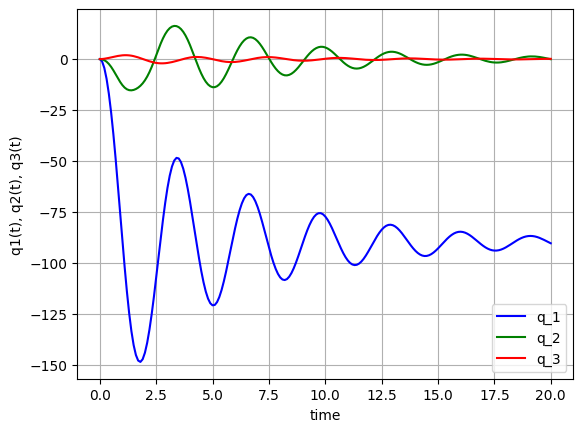

In [ ]:
import Animation as anim
import numpy as np
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
from Model import model_nlin
#from Vorsteuerung import *







x0=[-np.pi/2*0,0,0,  0,0,0, 0,0,0 ,0]       # x0 = [q1,q2,q3,qd1,qd2,qd3,qdd1,qdd2,qdd3, fx]

# define the discretization points
t_start = 0
t_stop = 20
dt = 1e-1

t_sim = np.linspace(t_start, t_stop, int((t_stop - t_start) / dt + 1))


# Define the controller
class Controller:
  def __init__(self,t):          
    self.ctr   = 'keinen'                           
    # Kraftregelung     
    self.fx     = 0                                                   # Momentane externe Kraft
    # Allgemein
    self.u     = [0,0,0]                                              # manuelle Vorgabe für den Eingang
    self.t     = t_sim


controller = Controller(t_sim)

#Wrapper für rechte Seite der Differentialgleichung
rhs=lambda t,x:model_nlin(t,x,controller)
    
solOde = solve_ivp(rhs,                  #zu simulierendes Modell
                    [t_start,t_stop],    #Zeitspanne für Simulation
                    x0,                  #Anfangszustand 
                    t_eval=t_sim,        #Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6  #Toleranzen
                    )


plt.plot(solOde.t, solOde.y[0]*180/np.pi, 'b', label='q_1')
plt.plot(solOde.t, solOde.y[1]*180/np.pi, 'g', label='q_2')
plt.plot(solOde.t, solOde.y[2]*180/np.pi, 'r', label='q_3')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('q1(t), q2(t), q3(t)')
plt.grid()
plt.show()

anim.plot(solOde.y[0],solOde.y[1],solOde.y[2],dt)

# 5. Reglerentwurf und Simulation
- Entwurf einer Position- / Kraftregelung
- Simulation und graphische Darstellung

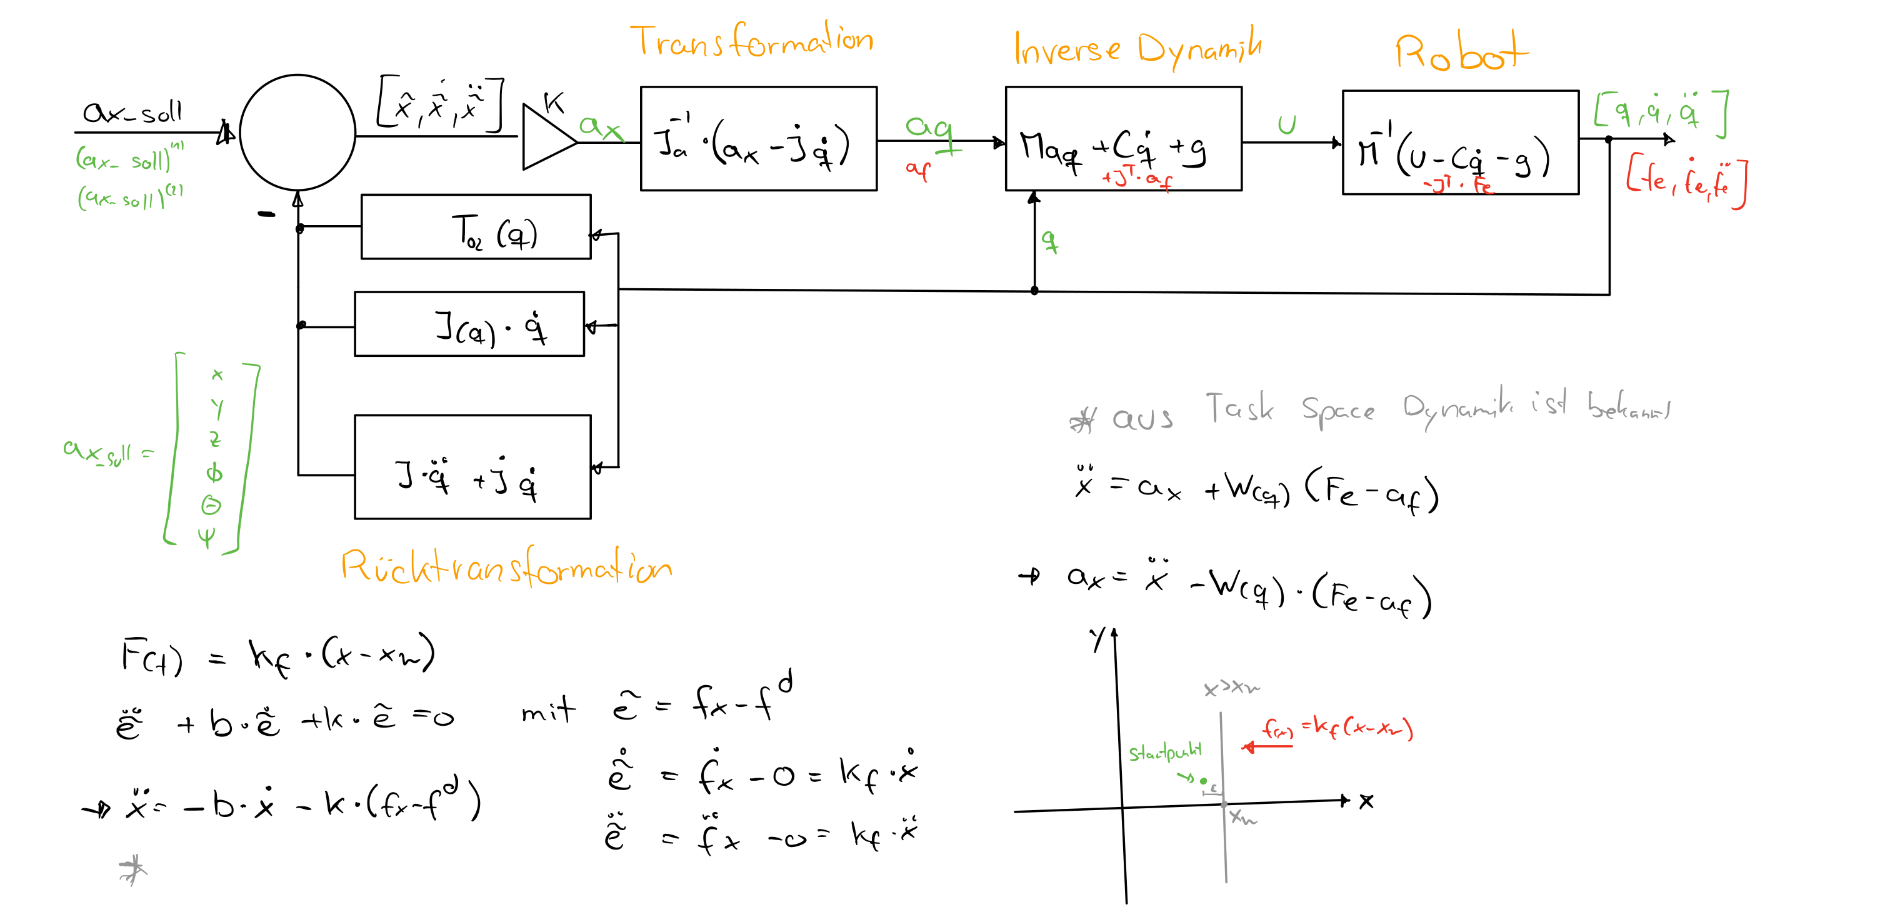

Die Grafik stellt den Signalfluss der Positions- und Kraftregelung(rot) dar.  
Der Eingang besteht dabei aus der Position in y-Richtung der Drehung des Endeffektors und dem Anpressdruck in x-Richtung.  
Diese werden im Arbeitsraum geplant und geregelt. Anschließend werden die Sollbeschleunigungen/Momente in den Gelenksraum übetragen ***transform_K_to_J(x)*** und dienen als "Eingang" für die inverse Dynamik. Die aktuellen Gelenkspositionen, Geschwindigkeiten, Beschleunigungen können aus dem Modell ***model_nlin*** ausgelsen und in den Arbeitsraum umgerechnet werden ***transform_J_to_K(x)***. Dort können die Ergebnisse zur Auswertung des Reglers herangezogen werden.    


### **Posititionsregler**  

$
a_{x} = \ddot{X^{d}} - K_{0}(X-X^{d}) - K_{1}(\dot{X}-\dot{X^{d}})  \\
X = 
\begin{bmatrix}
y  \\
\phi
\end{bmatrix}
$


### **Kraftregler** 

$
a_{x} = \ddot{X^{d}} - W(q)(F_{e}-a{f})   \\
W(q) = J_{a}(q)M^{-1}(q)J^{T}_{a}(q)      \\
\ddot{X^{d}} = -b\dot{x} - k(f_{x}-f^{d})
$ 



In [ ]:
'''
Inverse Kinematik zur Überprüfung der Start und Zielposition
'''
import numpy as np
from numpy import cos, sin
from scipy.optimize import fsolve
import Parameter as param

def T0e(q,x,y,z=0, eps=1e-3):
    # Position welche Angefahren werden soll   
    
    q1,q2,q3 = q[0],q[1],q[2]

    T = np.array([  param.l1*cos(q1) + param.l2*cos(q1 + q2) + param.l3*cos(q1 + q2 + q3) -x+eps,
                    param.l1*sin(q1) + param.l2*sin(q1 + q2) + param.l3*sin(q1 + q2 + q3) -y,
                                                                                       0 -z ])    
    return T

def minimieren(root):
    for i in range(3):
     while abs(root[i]) > 2*np.pi:
        if root[i] > 0:
            root[i] -= (2*np.pi)
        else: root[i] += (2*np.pi)
    return root 


# Vorgabe der Zielpunkte
P0 = [1,-1,5]
P1 = [1,1]
#[-np.pi*3/5, np.pi*2/5, np.pi*1/3]
P0s = minimieren(fsolve(T0e, [-np.pi/2, np.pi/2, 1e-1], args=(P0[0], P0[1]) ))
P1s = minimieren(fsolve(T0e, [0,0,0], args=(P1[0], P1[1]) ))

display('Start',P0s)
display('Ziel', P1s)

'Start'

array([-2.08708247,  1.96666046,  0.1       ])

'Ziel'

array([ 5.84555375, -4.55857624,  0.66666629])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


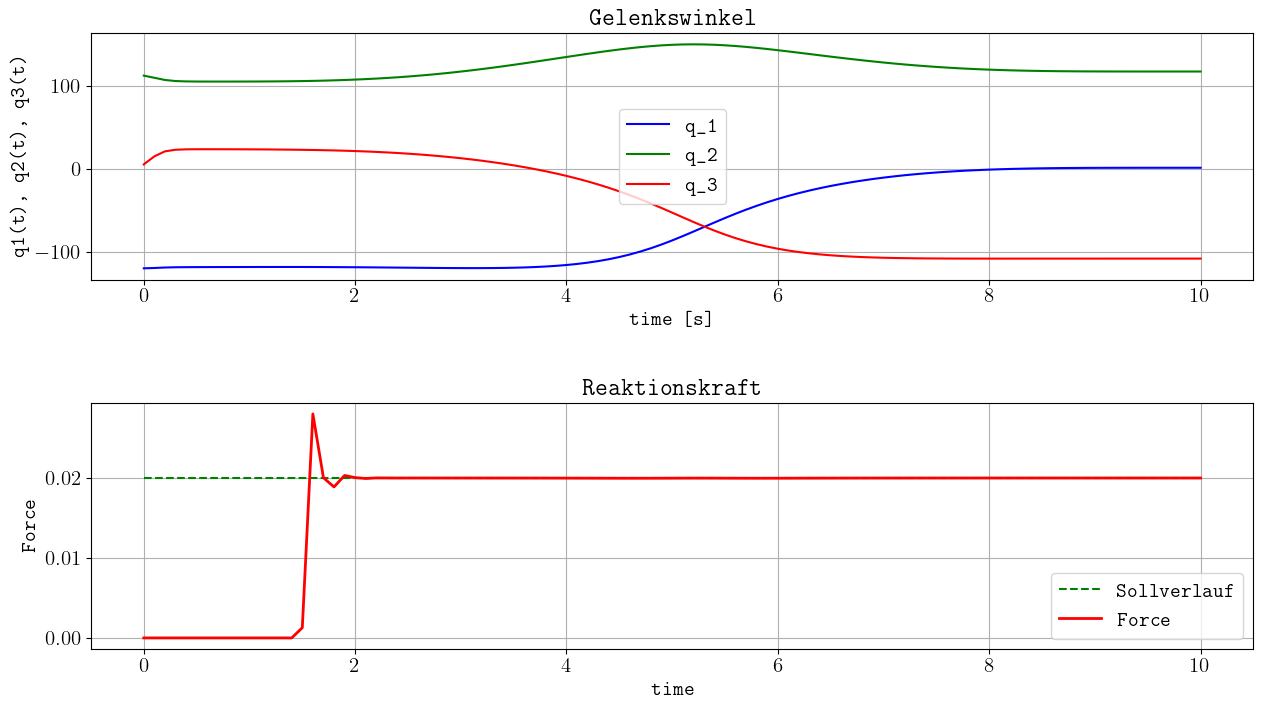

In [ ]:
%load_ext autoreload
%autoreload 2


import Animation as anim
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from Model import model_nlin
from Vorsteuerung import *




# x0 = [q1,q2,q3,qd1,qd2,qd3]
# Definieren der Start und Zielposition im Arbeitsraum
phi,y = np.array([1/5,1/5]), np.array([P0[1],P1[1]])

#definition der Ausgangskonfiguration des Roboters
x0=[P0s[0], P0s[1], P0s[2], 0,0,0, 0,0,0, 0]     # [q1,q2,q3, qd1, qd2, qd3, qdd1, qdd2, qdd3, F]  


# define the discretization points
t_start = 0
t_stop = 10
dt = 1e-1

t_sim = np.linspace(t_start, t_stop, int((t_stop - t_start) / dt + 1))


# Define the controller
class Controller:
  def __init__(self,u,t_sim):    
    # Positionsregelung
    self.w     =  np.array([20, 20])                                  # Reglerverstärung für jedes Gelenk      
    self.ctr   = 'multivariable'                                     # Auswahl Reglertyp    
    self.k0    = np.diag(np.array([self.w[0]**2,self.w[1]**2]))      # Reglerverstärkung
    self.k1    = np.diag(np.array([self.w[0]*2,self.w[1]*2]))        # Reglerverstärkung
    self.ax    = u                                                   # u = [y,phi, yd, phid, ydd, phidd] 
    # Kraftregelung
    self.kf     = 100                                                 # Federkonstante
    self.xw     = 1                                                   # x-Position bei der die äußere Kraft beginnen soll
    self.kb     = 20                                                  # Reglerverstärkung bf    --> Geschwindigkeit bestrafen
    self.kd     = 5                                                  # Reglerverstärung  df   --> Anpressdruck abweichung
    self.fsoll  = 2e-2                                                # Anpressdruck          
    self.fx     = 0                                                   # Momentane externe Kraft    
    # Allgemein
    self.u     = [0,0,0]                                              # manuelle Vorgabe für den Eingang
    self.t     = t_sim
    

## Trajektorienplanung im Arbeitsraum
ax1 = flat_output(t_stop,t_sim,3,y[0],y[1])
ax2 = flat_output(t_stop,t_sim,3,phi[0],phi[1])

ax= np.vstack((ax1[0,:],ax2[0,:],ax1[1,:],ax2[1,:],ax1[2,:],ax2[2,:]))

controller = Controller(ax,t_sim)


#Wrapper für rechte Seite der Differentialgleichung
rhs=lambda t,x:model_nlin(t,x,controller)
    
solOde = solve_ivp(rhs,                  #zu simulierendes Modell
                    [t_start,t_stop],    #Zeitspanne für Simulation
                    x0,                  #Anfangszustand 
                    t_eval=t_sim,        #Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6  #Toleranzen
                    )




''' PLOT '''
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "monospace",
    "font.monospace": 'Computer Modern Typewriter',  
    "font.size": 15.0 
})
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.5)
fig.set_size_inches(15,8)
ax1.set_title('Gelenkswinkel')
ax1.plot(solOde.t, solOde.y[0]*180/np.pi, 'b', label='q_1')
ax1.plot(solOde.t, solOde.y[1]*180/np.pi, 'g', label='q_2')
ax1.plot(solOde.t, solOde.y[2]*180/np.pi, 'r', label='q_3')
ax1.legend(loc='best')
ax1.set_xlabel('time [s]')
ax1.set_ylabel('q1(t), q2(t), q3(t)')
ax1.grid()


ax2.set_title('Reaktionskraft')
ax2.plot(solOde.t, np.ones(len(solOde.t))*controller.fsoll, 'g',linestyle='--', label='Sollverlauf')
ax2.plot(solOde.t, solOde.y[9], 'r',linewidth='2',  label='Anpressdruck')
ax2.legend(loc='best')
ax2.set_ylabel('Anpressdruck')
ax2.set_xlabel('time')
ax2.grid()
plt.show()

In [ ]:
anim.plot(solOde.y[0],solOde.y[1],solOde.y[2],dt)

# 6 Diskussion

Bei der Bestimmung der Inversen Jacobimatrix wird mit Hilfe der Pseudoinversen gelöst. Diese Implementierung gibt einen zusätzliche Freiheitsgrade $\lambda$. Durch diese Art der Vorgehensweise streben die Gelenksgeschwindigkeiten nahe von Singularitäten einem endlichen Wert entgegen. Gleichzeitig wird Abseits von Singularitäten das volle Potential begrenzt. Eine Erweiterung kann eine dynamische Implementierung darstellen bei der $\lambda$ abhängig von der Gelenkswinkel oder Geschwindigkeiten gewählt wird.    

Die Simulation zeigt, dass ein 3R-Roboter mithilfe der Inversen Dynamik einer linearen Regelstruktur folgt. Desweiteren kann mir ihrer Hilfe der Endeeffektor einer vorgegebenen Trajektorie in y, als auch in $\phi$ Richtung folgen.  
Das Video zeigt gleichzeitig die Schwachstellen dieser Regelung ab. Obwohl die Position in y-Richtung eingehalten wird kommt das zweite Gelenk der Schranke bei $x_{w} = 1$ gefährlich nahe. Dies legt den Schluss nache, dass bei der Trajektorienplanung der gesamte Roboter berücksichtigt werden muss. Gleichzeitig muss eine Strategie zur interpretation der Inversen Kinematik bedacht werden. Dies hat große Bedeutung, wann die Ziel-POSE des Endeffektors mit mehreren Konfigurationen angefahren werden kann.  
Eine weitere Limitation ist, dass in diesem Modell keine Motor- oder Winkelbegrenzungen berücksichtigt wurden. 
 

Die Kraftregelung sorgt für eine Anziehung zum Gleichgewichtspunkt mit den äußeren Kräften. Soll die Kraftregelung kleinen Anpressdrücken folgen (<1e-2), führt dies zu einer verkleinerung der Regelgröße im Vergleich zur Positionsregelung. Die Folge ist, dass die Krafregelung mitunter den gewünschten Anpressdruck während der Trajektorienüberführung nicht erreichen kann. Eine Lösung für dieses Problem ist, vor Beginn der Überführung den gewünschten Anpressdruck herzustellen und anschließend die Überführung zu starten. Damit kann der Anpressdruck von Beginn der Überführung gewähleistet werden. Eine zweite Möglichkeit ist die Erhöhung der Regelverstärkung.  

